In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/example_imagess/train.tar.gz"
data_dir = tf.keras.utils.get_file('train.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [3]:
image_count = len(list(data_dir.glob('*/*.JPG')))
print(image_count)

39152


In [4]:
import pathlib
import PIL
import tensorflow as tf

dataset_url = "https://storage.googleapis.com/example_imagess/train.tar.gz"
data_dir = tf.keras.utils.get_file('train.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

# 1. Print data_dir to verify the extraction path:
print(f"Data directory: {data_dir}")

# 2. List all files and directories in data_dir:
print(f"Files and directories in data_dir:")
for item in data_dir.iterdir():
    print(item)

# 3. Use a more general glob pattern:
Blueberry___healthy = list(data_dir.glob('**/*.JPG'))  # Search recursively for JPG files

# 4. Check if any files were found:
if Blueberry___healthy:
    # If files were found, open the first one
    PIL.Image.open(str(Blueberry___healthy[0]))
else:
    # If no files were found, print an error message
    print("No image files found in the specified directory.")

Data directory: C:\Users\MSIS\.keras\datasets\train
Files and directories in data_dir:
C:\Users\MSIS\.keras\datasets\train\Apple___Apple_scab
C:\Users\MSIS\.keras\datasets\train\Apple___Black_rot
C:\Users\MSIS\.keras\datasets\train\Apple___Cedar_apple_rust
C:\Users\MSIS\.keras\datasets\train\Apple___healthy
C:\Users\MSIS\.keras\datasets\train\Blueberry___healthy
C:\Users\MSIS\.keras\datasets\train\Cherry_(including_sour)___healthy
C:\Users\MSIS\.keras\datasets\train\Cherry_(including_sour)___Powdery_mildew
C:\Users\MSIS\.keras\datasets\train\Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
C:\Users\MSIS\.keras\datasets\train\Corn_(maize)___Common_rust_
C:\Users\MSIS\.keras\datasets\train\Corn_(maize)___healthy
C:\Users\MSIS\.keras\datasets\train\Corn_(maize)___Northern_Leaf_Blight
C:\Users\MSIS\.keras\datasets\train\Pepper,_bell___Bacterial_spot
C:\Users\MSIS\.keras\datasets\train\Pepper,_bell___healthy
C:\Users\MSIS\.keras\datasets\train\Potato___Early_blight
C:\Users\MSIS\.keras\da

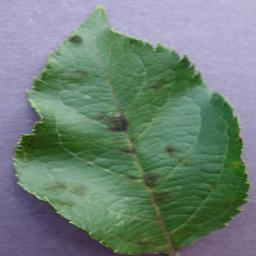

In [5]:
Apple_scrab = list(data_dir.glob('Apple___Apple_scab/*'))
PIL.Image.open(str(Apple_scrab[0]))

In [6]:
from PIL import Image

# Instead of PIL.Image.shape(str(tulips[1])), use the following:
img = Image.open(str(Apple_scrab[1]))
img_shape = img.size  # Get the image size (width, height)

print(img_shape)

(256, 256)


In [7]:
batch_size = 64
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 39152 files belonging to 21 classes.
Using 31322 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 39152 files belonging to 21 classes.
Using 7830 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy']


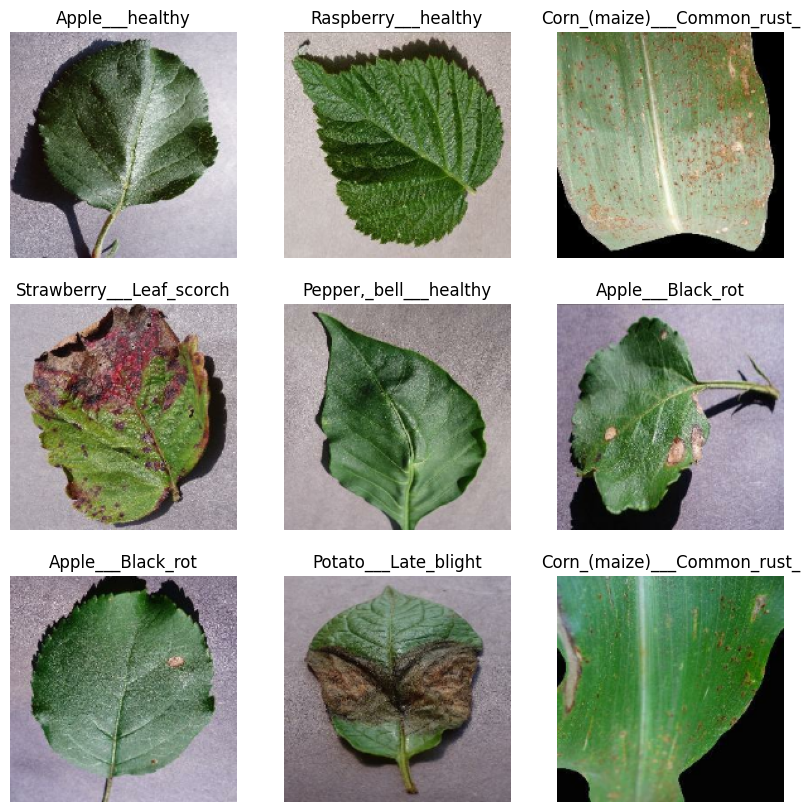

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 3)
(64,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9555489


In [16]:
num_classes = len(class_names)
num_classes

21

In [17]:
# Define the EfficientNet model as a feature extractor
base_model = ResNet50(weights='imagenet',  # Load pre-trained weights
                            include_top=False,   # Exclude the top fully connected layers
                            input_shape=(img_height, img_width, 3))  # Use your input shape

# Freeze the base model layers so they aren't trained again
base_model.trainable = False

# Create the new model on top of the EfficientNet base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global average pooling to reduce the dimensions
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dense(num_classes, activation='softmax')  # Output layer (softmax for classification)
])


94765736/94765736 [==============================] - 41s 0us/step


In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 21)                2709      
                                                                 
Total params: 23852693 (90.99 MB)
Trainable params: 264981 (1.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [22]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15



c:\Users\MSIS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



490/490 [==============================] - 618s 1s/step - loss: 0.2198 - accuracy: 0.9384 - val_loss: 0.0901 - val_accuracy: 0.9692
Epoch 2/15
490/490 [==============================] - 711s 1s/step - loss: 0.0536 - accuracy: 0.9842 - val_loss: 0.0963 - val_accuracy: 0.9691
Epoch 3/15
490/490 [==============================] - 710s 1s/step - loss: 0.0379 - accuracy: 0.9876 - val_loss: 0.0414 - val_accuracy: 0.9863
Epoch 4/15
490/490 [==============================] - 710s 1s/step - loss: 0.0256 - accuracy: 0.9913 - val_loss: 0.0383 - val_accuracy: 0.9872
Epoch 5/15
490/490 [==============================] - 710s 1s/step - loss: 0.0201 - accuracy: 0.9933 - val_loss: 0.0335 - val_accuracy: 0.9880
Epoch 6/15
490/490 [==============================] - 566s 1s/step - loss: 0.0203 - accuracy: 0.9934 - val_loss: 0.0378 - val_accuracy: 0.9875
Epoch 7/15
490/490 [==============================] - 496s 1s/step - loss: 0.0150 - accuracy: 0.9946 - val_loss: 0.0474 - val_accuracy: 0.9842
Epoch 8/1

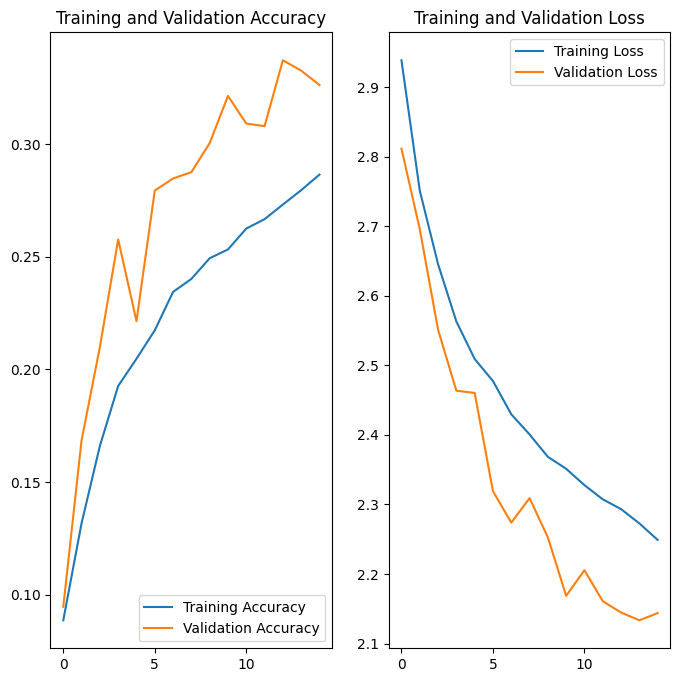

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

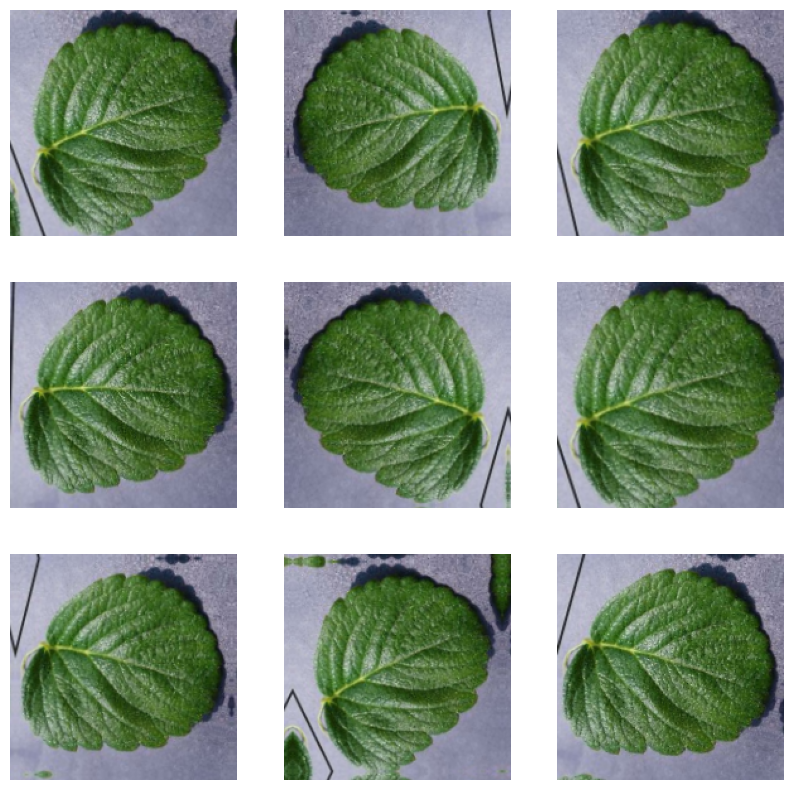

In [33]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [34]:
num_classes = len(class_names)
num_classes

21

In [35]:
model = models.Sequential([
    data_augmentation,                     # Data augmentation layer (if defined)
    layers.Rescaling(1./255),              # Rescale pixel values

    base_model,                            # ResNet50 as the feature extractor
    layers.GlobalAveragePooling2D(),       # Global pooling to reduce dimensions
    layers.Dropout(0.2),                   # Dropout layer for regularization

    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dense(num_classes, activation='softmax', name="outputs")  # Output layer with softmax
])

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


c:\Users\MSIS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


490/490 [==============================] - 639s 1s/step - loss: 2.9384 - accuracy: 0.0886 - val_loss: 2.8114 - val_accuracy: 0.0946
Epoch 2/15
490/490 [==============================] - 642s 1s/step - loss: 2.7511 - accuracy: 0.1318 - val_loss: 2.6958 - val_accuracy: 0.1686
Epoch 3/15
490/490 [==============================] - 729s 1s/step - loss: 2.6453 - accuracy: 0.1660 - val_loss: 2.5512 - val_accuracy: 0.2100
Epoch 4/15
490/490 [==============================] - 754s 2s/step - loss: 2.5630 - accuracy: 0.1927 - val_loss: 2.4634 - val_accuracy: 0.2577
Epoch 5/15
490/490 [==============================] - 698s 1s/step - loss: 2.5091 - accuracy: 0.2047 - val_loss: 2.4603 - val_accuracy: 0.2215
Epoch 6/15
490/490 [==============================] - 670s 1s/step - loss: 2.4773 - accuracy: 0.2174 - val_loss: 2.3190 - val_accuracy: 0.2794
Epoch 7/15
490/490 [==============================] - 735s 2s/step - loss: 2.4296 - accuracy: 0.2344 - val_loss: 2.2738 - val_accuracy: 0.2848
Epoch 8/15

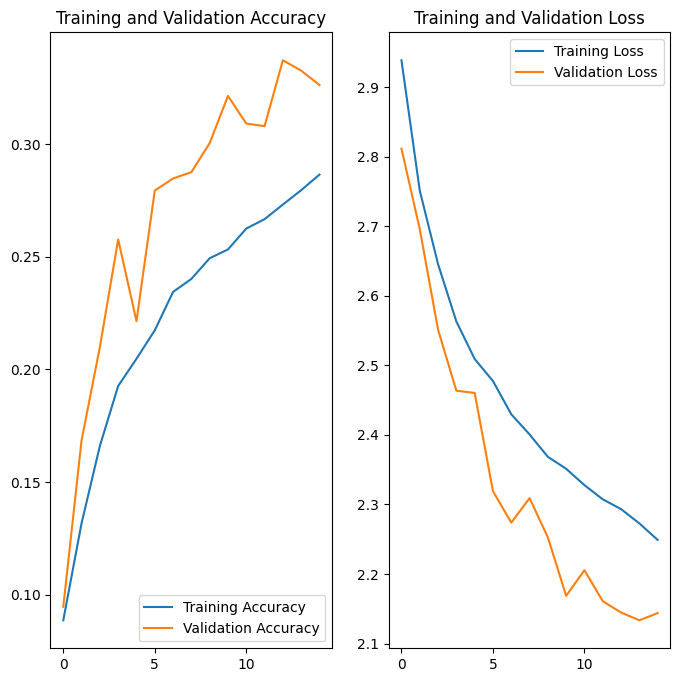

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
# Make predictions
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

123/123 [==============================] - 101s 814ms/step


In [43]:
# Get true labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

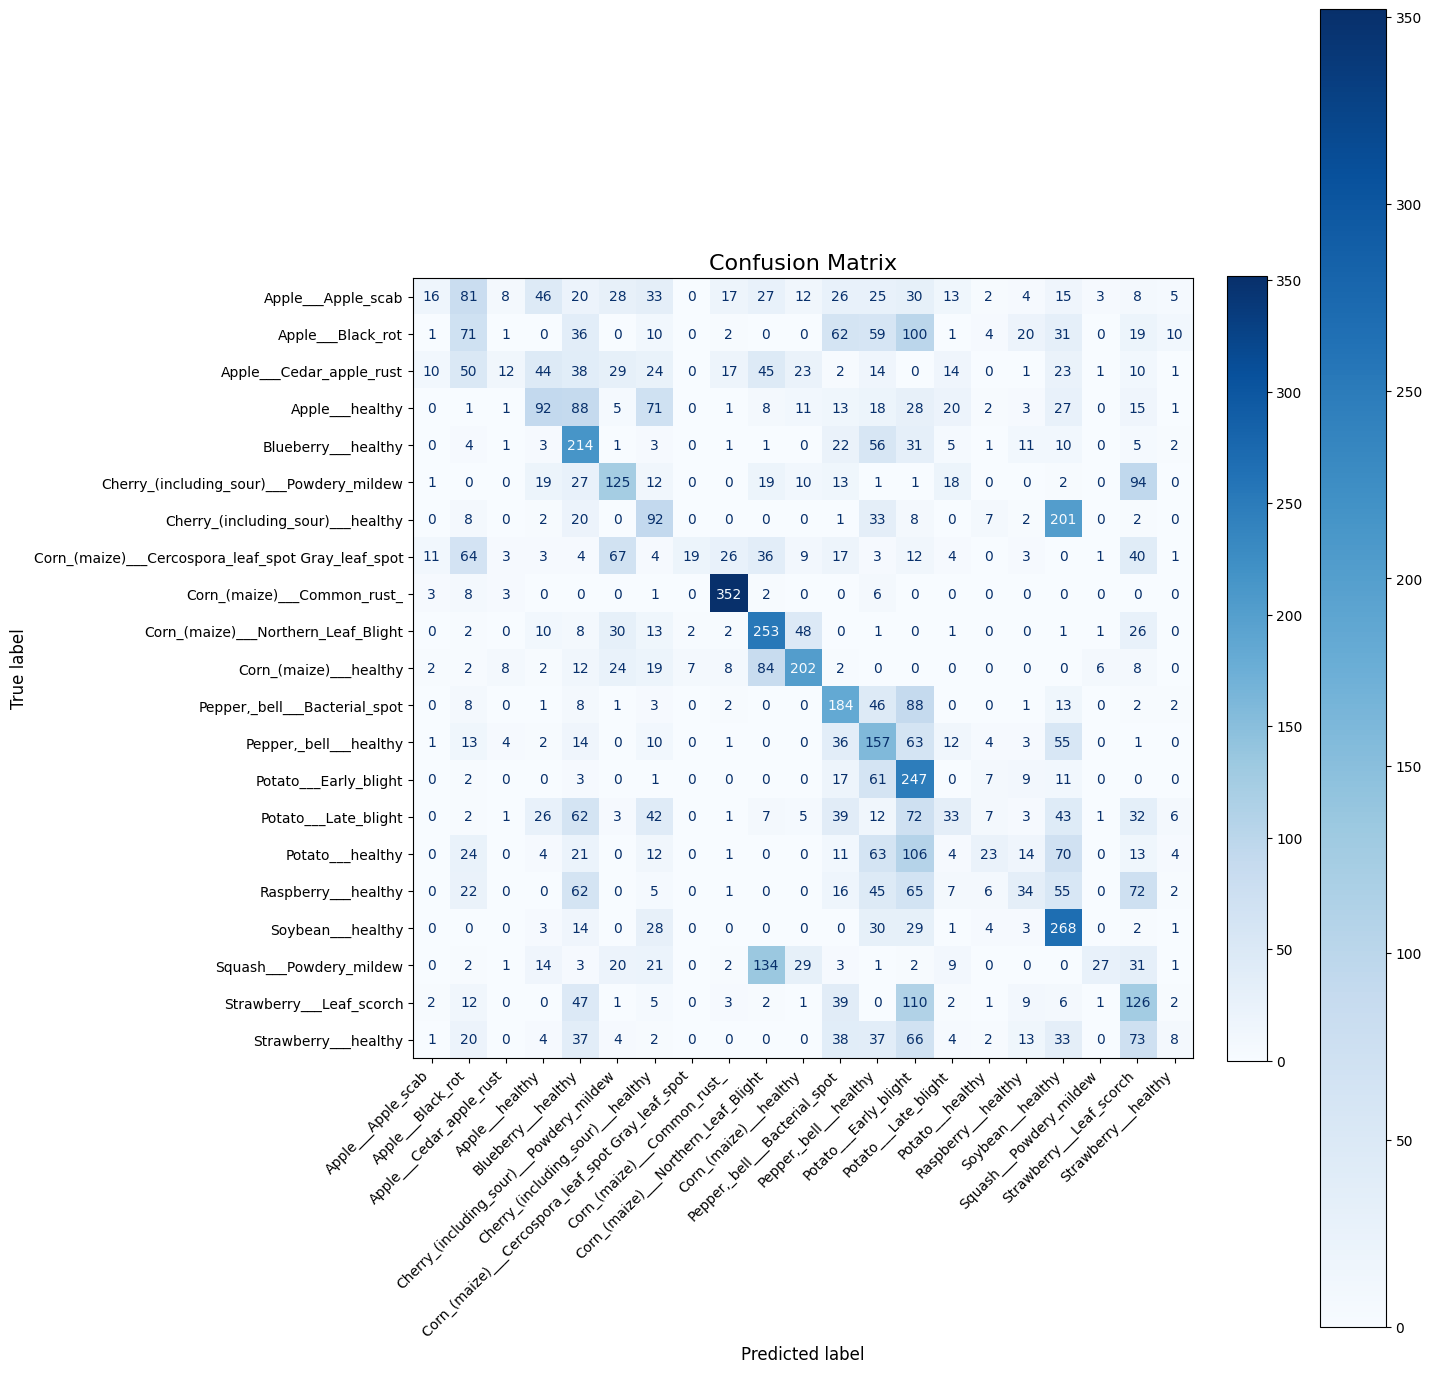

In [45]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix with improvements
fig, ax = plt.subplots(figsize=(15, 15))  # Increase figure size for readability
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.0f')  # Display integer format

# Adjustments for readability
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels and adjust font size
plt.yticks(fontsize=10)  # Adjust y-axis font size
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.grid(False)  # Optional: Disable grid if it’s distracting
plt.colorbar(disp.im_, fraction=0.046, pad=0.04)  # Customize colorbar position

plt.tight_layout()  # Automatically adjust layout
plt.show()

In [46]:
from sklearn.metrics import classification_report

# Assuming y_true and y_pred_classes are already defined
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.33      0.04      0.07       419
                                 Apple___Black_rot       0.18      0.17      0.17       427
                          Apple___Cedar_apple_rust       0.28      0.03      0.06       358
                                   Apple___healthy       0.33      0.23      0.27       405
                               Blueberry___healthy       0.29      0.58      0.39       371
          Cherry_(including_sour)___Powdery_mildew       0.37      0.37      0.37       342
                 Cherry_(including_sour)___healthy       0.22      0.24      0.23       376
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.68      0.06      0.11       327
                       Corn_(maize)___Common_rust_       0.81      0.94      0.87       375
               Corn_(maize)___Northern_Leaf_Blight       0.41      0.64      0.

In [47]:
Apple_url = "https://storage.googleapis.com/example_imagess/AppleCedarRust4.JPG"

# Download the image and load it
Apple_path = tf.keras.utils.get_file('test', origin=Apple_url)
img = tf.keras.utils.load_img(Apple_path, target_size=(img_height, img_width))

# Convert the image to an array and expand dimensions to create a batch
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)  # Create a batch of size 1

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Print the result
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 560ms/step
This image most likely belongs to Cherry_(including_sour)___Powdery_mildew with a 5.13 percent confidence.


In [48]:
Apple_url = "https://storage.googleapis.com/example_imagess/00a6039c-e425-4f7d-81b1-d6b0e668517e___RS_HL%207669.JPG"

# Download the image and load it
Apple_path = tf.keras.utils.get_file('Apple_healthy', origin=Apple_url)
img = tf.keras.utils.load_img(Apple_path, target_size=(img_height, img_width))

# Convert the image to an array and expand dimensions to create a batch
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)  # Create a batch of size 1

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Print the result
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 71ms/step
This image most likely belongs to Apple___healthy with a 5.17 percent confidence.
